Constant features excluded: ['EmployeeCount', 'Over18', 'StandardHours']
Input shape for ANN: 45
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2944      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [====

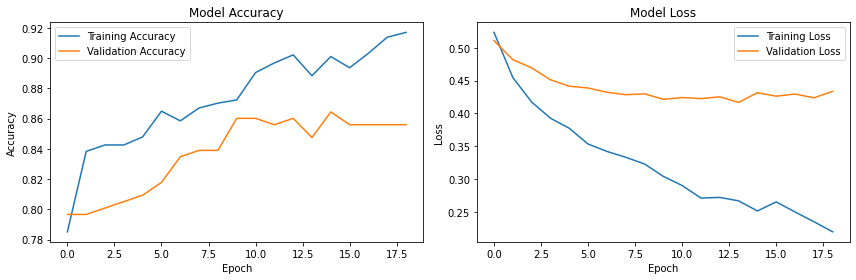

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/home/suhas/Desktop/office/Data Science/Notes/Data Analysis/Data/HR-Employee-Attrition.csv')

# Identify all features except 'Attrition'
all_features = df.columns.drop('Attrition')

# Identify constant features (features with only one unique value)
constant_features = [col for col in all_features if df[col].nunique() <= 1]
print("Constant features excluded:", constant_features)

# Exclude constant features from the feature set
features_to_use = [col for col in all_features if col not in constant_features]

# Separate into numerical and categorical features dynamically
num_features = df[features_to_use].select_dtypes(include=['number']).columns.tolist()
cat_features = df[features_to_use].select_dtypes(include=['object']).columns.tolist()

# Select features (X) and target (y)
X = df[features_to_use]
y = df['Attrition']

# Encode the target variable ('Yes' -> 1, 'No' -> 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define preprocessing pipelines
# Numerical pipeline: impute missing values, apply robust scaling, then standard scaling
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('robust', RobustScaler()),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values, one-hot encode with drop='first'
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num_pipe', num_pipeline, num_features),
    ('cat_pipe', cat_pipeline, cat_features)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get the input shape for the ANN (number of features after preprocessing)
input_shape = X_train_preprocessed.shape[1]
print(f"Input shape for ANN: {input_shape}")

# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Display model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_preprocessed)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)

print("\n=== ANN Model Evaluation (Initial Dataset) ===")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(clf_report)

# Save the model and preprocessing pipeline
model.save('ann_model_initial.h5')
joblib.dump(preprocessor, 'preprocess_pipeline_initial.pkl')
print("\nModel saved as 'ann_model_initial.h5' and preprocessing pipeline saved as 'preprocess_pipeline_initial.pkl'")

# Visualize training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()